# RvF: Real vs Fake face Detection

## Getting Started

To understand CNN theoretically, other than using online resources, you can refer to [CNN Crash Course (U-M Only)](https://docs.google.com/presentation/d/1p3EWFMfTNT773PEt3q16tlLxQ4FuD-JTwnTj1A_N4a0/edit?usp=sharing)

Here is also a guide on [PyTorch for CNNS](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/notebooks/pytorch_cnn.ipynb)

In [ ]:
import torch
import torchvision.transforms.v2 as v2
import torch
from torch import nn, optim
from starter_code.dataset import RvFDataset, get_loaders
from starter_code.train import train_model, plot_performance, load_model

## Step 1: Define Preprocessing

There are numerous advantages for preprocessing, depending on the topic of your program. For our project on CNN for RvF, the two major benefits of preprocessing are:

### Normalization
Normalization brings features onto a similar scale, preventing certain features from dominating the learning process due to larger magnitude. By normalizing the data, we ensure that each feature contributes proportionally to the learning process, leading to efficient convergence and model generalization.

### Generalization
Preprocessing techniques help to generalize the model better to unseen data by introducing variability in the training images. This prevents the model from overfitting to the training data. Examples of such preprocessing are random crop, random jitter, etc.

Here is a more detailed guide on [Image Preprocessing](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/notebooks/image_preprocessing.ipynb).

In [4]:
# load training dataset
train_dataset = RvFDataset("train", data_directory = "data/rvf10k")

In [5]:
# normalization is implemented for you, which is called in the next cell
mean = torch.zeros((3,))
variance = torch.zeros((3,))
tensor_converter = v2.ToTensor()

for image, _ in train_dataset:
    mean += tensor_converter(image).mean(dim=(1, 2))
    mean /= len(train_dataset)
for image, _ in train_dataset:
    image = tensor_converter(image)
    variance += ((image - mean.view(3, 1, 1))**2).mean(dim=(1, 2))

std = torch.sqrt(variance / len(train_dataset))

/opt/anaconda3/envs/esgdata/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [56]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

### TODO1: Define Your Preprocessing

In [6]:
def preprocess(image) -> torch.Tensor:

    """
    Preprocesses an image by applying a series of transformation.

    Args:
        image (npt.ArrayLike): The input image to be preprocessed.

    Returns:
        torch.Tensor: The preprocessed image as a tensor.
    """

    tensor = torch.tensor(image, dtype = torch.float32).permute(2, 0, 1) # convert image to tensor

    tensor = v2.Normalize(mean = mean, std = std)(tensor)

    # TODO: Add more preprocessing steps to improve model performance.
    
    
    return tensor

## Step 2: Model Definition

Below is an example of a class definition in Python for a very simple convolutional neural network called BasicCNN. Let's break its components down.

In [ ]:
class BasicCNN(nn.Module): # Net inherits from nn.Module
    def __init__(self):
        """Constructor for the neural network."""
        super(BasicCNN, self).__init__()        # Call superclass constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()              
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3200, 10)

    def forward(self, x):
        z1 = self.conv1(x)
        h1 = self.relu(z1)
        p1 = self.pool(h1)

        z2 = self.conv2(p1)
        h2 = self.relu(z2)
        p2 = self.pool(h2)

        flat = self.flatten(p2)
        z = self.fc(flat)

        return z

#### Subclass Inheritance

This first criteria is met by defining the subclass relationship between `BasicCNN` and `nn.Module`
- When we write the first line of the class defintion, we write `BasicCNN(nn.Module):` to indicate that `BasicCNN` is a subclass of `nn.Module`
- On line 4, we call the superclass constructor for this model:
  
  ```py
    super(BasicCNN, self).__init__() 
  ```

#### Layer Definition

For PyTorch to recognize that a layer is a part of our model, we must add all them as **member variables** of the `BasicCNN`. This can be done in the class constructor `__init__()` by evoking the `self` pointer:

```py
self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
self.conv2 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3, stride=1)
self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
self.relu = nn.ReLU()              
self.flatten = nn.Flatten()
self.fc = nn.Linear(3200, 10) 
```

This code defines 5 layers for our model:
- `conv1`: convolution layer that expects 1 channel and has 16 filters with filter size of 3 pixels and a stride of 1
- `conv2`: convolution layer that expects 16 channel and has 128 filters with filter size of 3 pixels and a stride of 1
- `pool`: max pooling layer that has a window size of 2 and a stride of 2. We will reuse this layer multiple times (since max pooling is stateless)
- `relu`: activation layer using the ReLU activation function. We will reuse this activation layer multiple times (since activation functions are stateless)
- `fc`: a dense layer that expects a vector with 3200 components and returns a vector with 10 components (one for each of the 10 classes in the MNIST dataset)

#### Defining the Forward Pass

The third criteria is more tricky - we have to define a function called `forward()` that specifies _how_ to call each layer and make predictions for some input image. For the model above, we have the following definition for this function

```py
def forward(self, x):
   z1 = self.conv1(x)
   h1 = self.relu(z1)
   p1 = self.pool(h1)

   z2 = self.conv2(p1)
   h2 = self.relu(z2)
   p2 = self.pool(h2)

   flat = self.flatten(p2)
   z = self.fc(flat)

   return z
```

Let's break down the first few lines of this function:
1. The `forward()` function takes as input the parameters
   1. `self` - is the self-pointer, is equivalent to `this` in C++
   2. `x` - the input to the model - in this case an image of a handwritten digit.
2. The image `x` is immediately passed as input into the first convolution layer `conv1` to perform convolution. The output of this convolution layer is saved to the local variable `z1`.
   1. Note that in this case, `self.conv` is actually a **functor** - it is an object that can be called like a function to produce an output
3. The convolution layer output `z1` is passed through the ReLU activation layer to get the activated outputs `h1`
4. The activated output has max pooling applied to downsample it, and the output is then saved the result to `p1`.
5. The pooled output is passed as input the second convolution layer `conv2` to perform another round of convolution. The output of this convolution layer is saved to the local variable `z2`
   1. 🚨 As `p1` has 16 channels, we MUST define `conv2` to accept 16 input channels. It is SUPER important to be careful to make sure that your input to your convolution layer has the correct number of channels, otherwise PyTorch will throw errors!
6. ...

And so forth! 

### TODO2: Define Your Model

Here are the restrictions:
- your first convolution layer must accept images that have only 4 channels
- your last convolution layer must accept images that have only 256 channels
- your CNN output should return a vector with 2 entries
- if you find difficulties in understanding the model, visit [Pytorch and CNN](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/notebooks/pytorch_cnn.ipynb)

Other than that, you have as much flexibility as you prefer for how you want to define your model!

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
      """Constructor for the neural network."""
      super(Model, self).__init__()        # Call superclass constructor

      # A few preprocessing ... 
      # You are free to add more or delete 

      self.channel_adjust = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, stride=1, padding=0)
      self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) 
      )
      self.last_conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) 
      )
      self.flatten = nn.Flatten()
      self.dense_layers = nn.Sequential(
        nn.Linear(512 * 32 * 32, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 2)
      )

    def forward(self, x):
      
      x = self.channel_adjust(x)
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = self.last_conv_layer(x)
      
      x = self.flatten(x)
      x = self.dense_layers(x)
      
      return x


## Step 3: Model Training


For model training, we utilized functions wirtten in starter_code directory located under "Optional-Challenge/RvF". They are ready to use, and feel free to refer back to them.

Batch Accuracy: 0.62 , Total Accuracy: 0.51: 100%|██████████| 438/438 [35:16<00:00,  4.83s/it]


Epoch 1: Loss - (Train 3564.54/Val 0.04), Accuracy - (Train 0.51/Val 0.52)


Batch Accuracy: 0.75 , Total Accuracy: 0.54: 100%|██████████| 438/438 [3:37:27<00:00, 29.79s/it]   


Epoch 2: Loss - (Train 316.81/Val 0.04), Accuracy - (Train 0.54/Val 0.54)


Batch Accuracy: 0.75 , Total Accuracy: 0.57: 100%|██████████| 438/438 [34:04<00:00,  4.67s/it]


Epoch 3: Loss - (Train 294.98/Val 0.05), Accuracy - (Train 0.57/Val 0.55)


Batch Accuracy: 0.75 , Total Accuracy: 0.60: 100%|██████████| 438/438 [38:40<00:00,  5.30s/it]


Epoch 4: Loss - (Train 285.51/Val 0.05), Accuracy - (Train 0.60/Val 0.57)


Batch Accuracy: 0.50 , Total Accuracy: 0.63: 100%|██████████| 438/438 [41:37<00:00,  5.70s/it]


Epoch 5: Loss - (Train 270.37/Val 0.05), Accuracy - (Train 0.63/Val 0.56)


Batch Accuracy: 0.38 , Total Accuracy: 0.68: 100%|██████████| 438/438 [55:21<00:00,  7.58s/it]   


Epoch 6: Loss - (Train 249.14/Val 0.05), Accuracy - (Train 0.68/Val 0.58)


Batch Accuracy: 0.75 , Total Accuracy: 0.72: 100%|██████████| 438/438 [1:30:05<00:00, 12.34s/it]  


Epoch 7: Loss - (Train 227.49/Val 0.06), Accuracy - (Train 0.72/Val 0.59)


Batch Accuracy: 0.75 , Total Accuracy: 0.76: 100%|██████████| 438/438 [37:10<00:00,  5.09s/it]


Epoch 8: Loss - (Train 201.17/Val 0.08), Accuracy - (Train 0.76/Val 0.61)


Batch Accuracy: 0.62 , Total Accuracy: 0.78: 100%|██████████| 438/438 [37:28<00:00,  5.13s/it]


Epoch 9: Loss - (Train 218.62/Val 0.07), Accuracy - (Train 0.78/Val 0.56)


Batch Accuracy: 0.62 , Total Accuracy: 0.76: 100%|██████████| 438/438 [39:17<00:00,  5.38s/it]


Epoch 10: Loss - (Train 237.19/Val 0.08), Accuracy - (Train 0.76/Val 0.56)


TypeError: 'PosixPath' object is not callable

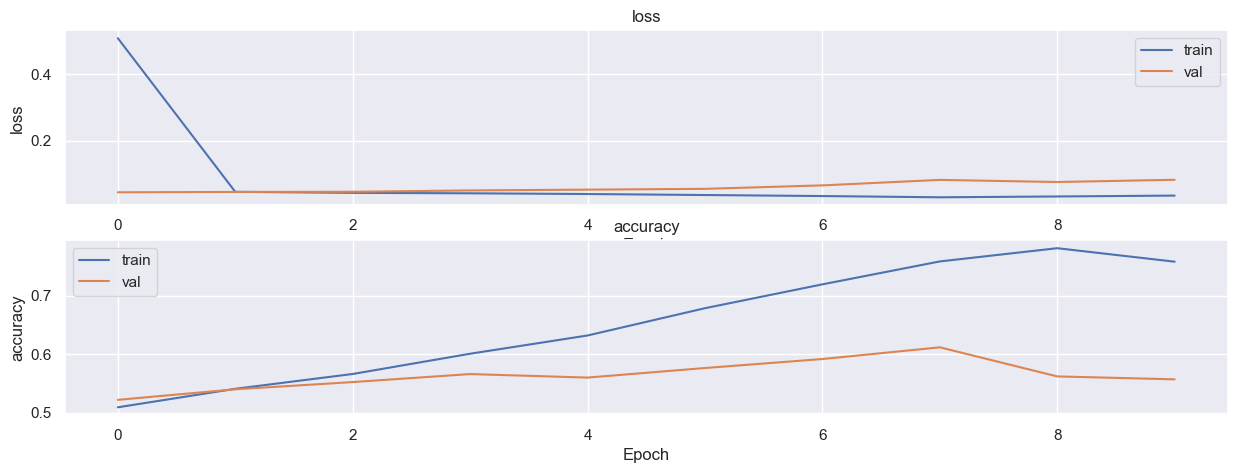

In [ ]:
train_loader, val_loader = get_loaders(batch_size = 16, preprocessor = preprocess, data_directory = "data/rvf10k")

model = Model()

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4) # TODO: Change the optimizer to explore different options
criterion = torch.nn.CrossEntropyLoss() # TODO: Change the criterion to explore different options

history = train_model(model, criterion, optimizer, train_loader, val_loader)
plot_performance(history)

# Load the model from the training run
load_model(model, "checkpoints", 10) # you can modify the number of epochs, currently set at 10

#there's an error at the bottom because my laptop turned off mid way

This is the end of RvF challenge! Please save your file and submit your work.